In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [14, 7]
import statsmodels.api as sm

In [2]:
catalog = pd.read_csv("../helper/catalog.csv")
data = pd.read_csv("../output/2020-06-01_database_tf.csv", parse_dates=["date"])
ys = ["x_world.sa", "x_vol_world2.sa", "x_servs_world.sa"]

In [59]:
x = data.loc[:, pd.unique(["date"] + catalog.loc[~pd.isna(catalog.octave_value), "octave_value"].to_list())].set_index("date")
x.iloc[:-2] = x.iloc[:-2].interpolate()
x = x.iloc[:-30]

/home/danhopp/miniconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


MAE: 0.0113


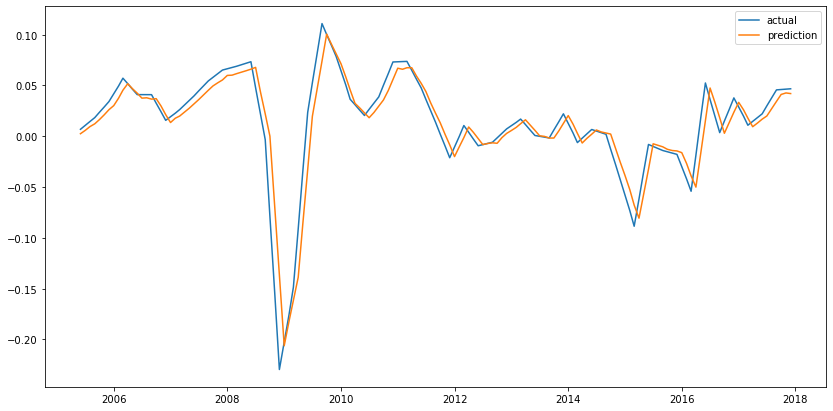

In [60]:
# model
mod = sm.tsa.DynamicFactor(x, k_factors=1, factor_order=1, error_order=1)
initial_res = mod.fit(method='powell', disp=False)
res = mod.fit(initial_res.params, disp=False)
#print(res.summary(separate_params=False))

# results
results = x.loc[~pd.isna(x["x_world.sa"]),:].join(res.predict()["x_world.sa"], how="left", rsuffix="pred")[["x_world.sa", "x_world.sapred"]]
results.columns = ["actual", "predicted"]
mae = np.abs(results.actual - results.predicted).mean()
print(f"MAE: {mae.round(4)}")
plt.plot(results.actual, label="actual")
plt.plot(results.predicted, label="prediction")
plt.legend();

In [61]:
res.forecast(4)

,x_cn.sa,x_us.sa,x_kr.sa,ipi_us.sa,ipi_jp.sa,ipi_kr.sa,cci_cn.sa,bci_cn.sa,bci_oecd.sa,freight_mar_cn.sa,x_hk.sa,p_manuf.sa,x_world.sa,x_vol_world.sa,x_uv_world.sa,container_index.sa,container_sg.sa,p_comm.sa
2018-01-01,0.011055,0.006642,0.015200,0.003220,0.006911,0.013896,0.001346,-0.001314,0.000069,0.010265,0.006592,0.004935,0.042090,0.007246,0.008646,0.009611,0.016507,0.019991
2018-02-01,0.016312,0.010802,0.015557,0.002710,0.005820,0.005561,0.001090,-0.000877,0.000037,0.003414,0.010945,0.003616,0.038036,0.005604,0.006406,0.003305,0.004958,0.018559
2018-03-01,0.009614,0.007190,0.011241,0.002253,0.004836,0.005770,0.000884,-0.000571,0.000012,0.004348,0.006410,0.002930,0.034445,0.004801,0.005118,0.005222,0.006378,0.015697
2018-04-01,0.010174,0.006581,0.010319,0.001872,0.004020,0.004576,0.000718,-0.000359,-0.000007,0.003168,0.006649,0.002424,0.031256,0.003941,0.004199,0.003032,0.004720,0.013085


q4 2019: actual: -0.003199
1 month ahead: -0.003447
2 months ahead: -0.003828
3 months ahead: -0.002767
4 months ahead: -0.007651

q1 2018: actual: 0.022400
1 month ahead: 0.027508
2 months ahead: 0.031798
3 months ahead: 0.034445

# FRED example

In [21]:
from pandas_datareader.data import DataReader
start = '1979-01-01'
end = '2014-12-01'
indprod = DataReader('IPMAN', 'fred', start=start, end=end)
income = DataReader('W875RX1', 'fred', start=start, end=end)
sales = DataReader('CMRMTSPL', 'fred', start=start, end=end)
emp = DataReader('PAYEMS', 'fred', start=start, end=end)
dta = pd.concat((indprod, income, sales, emp), axis=1)
dta.columns = ['indprod', 'income', 'sales', 'emp']
# Create log-differenced series
dta['dln_indprod'] = (np.log(dta.indprod)).diff() * 100
dta['dln_income'] = (np.log(dta.income)).diff() * 100
dta['dln_sales'] = (np.log(dta.sales)).diff() * 100
dta['dln_emp'] = (np.log(dta.emp)).diff() * 100

# De-mean and standardize
dta['std_indprod'] = (dta['dln_indprod'] - dta['dln_indprod'].mean()) / dta['dln_indprod'].std()
dta['std_income'] = (dta['dln_income'] - dta['dln_income'].mean()) / dta['dln_income'].std()
dta['std_sales'] = (dta['dln_sales'] - dta['dln_sales'].mean()) / dta['dln_sales'].std()
dta['std_emp'] = (dta['dln_emp'] - dta['dln_emp'].mean()) / dta['dln_emp'].std()

In [24]:
endog = dta.loc['1979-02-01':, 'std_indprod':'std_emp']
mod = sm.tsa.DynamicFactor(endog, k_factors=1, factor_order=2, error_order=2)
initial_res = mod.fit(method='powell', disp=False)
res = mod.fit(initial_res.params, disp=False)
print(res.summary(separate_params=False))

/home/danhopp/miniconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                             Statespace Model Results                                            
Dep. Variable:     ['std_indprod', 'std_income', 'std_sales', 'std_emp']   No. Observations:                  431
Model:                                 DynamicFactor(factors=1, order=2)   Log Likelihood               -2065.023
                                                          + AR(2) errors   AIC                           4166.045
Date:                                                   Thu, 18 Jun 2020   BIC                           4239.235
Time:                                                           10:42:46   HQIC                          4194.943
Sample:                                                       02-01-1979                                         
                                                            - 12-01-2014                                         
Covariance Type:                                                     opg                

/home/danhopp/miniconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
